Import all libraries

In [28]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout, Conv2D, MaxPooling2D

Check GPU

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [31]:
BATCH_SIZE = 64
TARGET_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3) 

Load dataset

In [16]:
dataset_path = "/kaggle/input/gender-dataset/Dataset/"

train_dir = os.path.join(dataset_path, 'Train')
test_dir = os.path.join(dataset_path, 'Test')
val_dir = os.path.join(dataset_path, 'Validation')

# **Data preprocessing & augmentation**

In [32]:
train_datagen = ImageDataGenerator(rescale = 1./255,
      rotation_range=20,
      shear_range=0.2,
      zoom_range=0.20,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator( rescale = 1.0/255)

In [33]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'binary',
                                                    target_size = TARGET_SIZE )     

validation_generator =  test_datagen.flow_from_directory(val_dir,
                                                        batch_size  = BATCH_SIZE,
                                                        class_mode  = 'binary',
                                                        target_size = TARGET_SIZE)

test_generator =  test_datagen.flow_from_directory(test_dir,
                                                        batch_size  = BATCH_SIZE,
                                                        class_mode  = 'binary',
                                                        target_size = TARGET_SIZE)

Found 160000 images belonging to 2 classes.
Found 22598 images belonging to 2 classes.
Found 20001 images belonging to 2 classes.


In [37]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))  
model.add(MaxPooling2D(pool_size=(2, 2)))  

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

model.add(Dense(128 , activation='relu'))
model.add(Dropout(.3))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,521 (91.20 MB)

 Trainable params: 23,907,521 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

Compile model

In [38]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# **Training model**

In [39]:
history = model.fit(train_generator,
                    epochs=5, 
                    validation_data=validation_generator,
                    verbose=1)

Epoch 1/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1979s 785ms/step - accuracy: 0.8519 - loss: 0.3684 - val_accuracy: 0.9525 - val_loss: 0.1170
Epoch 2/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1931s 770ms/step - accuracy: 0.9355 - loss: 0.1616 - val_accuracy: 0.9564 - val_loss: 0.1071
Epoch 3/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1910s 762ms/step - accuracy: 0.9503 - loss: 0.1277 - val_accuracy: 0.9634 - val_loss: 0.0939
Epoch 4/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1871s 746ms/step - accuracy: 0.9556 - loss: 0.1159 - val_accuracy: 0.9648 - val_loss: 0.0892
Epoch 5/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1942s 775ms/step - accuracy: 0.9592 - loss: 0.1087 - val_accuracy: 0.9693 - val_loss: 0.0811


Plot for accuracy and loss trends.

In [40]:
def plot_image(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
    
    plt.show()
    
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend(loc=0)
    plt.figure()
    
    plt.show()

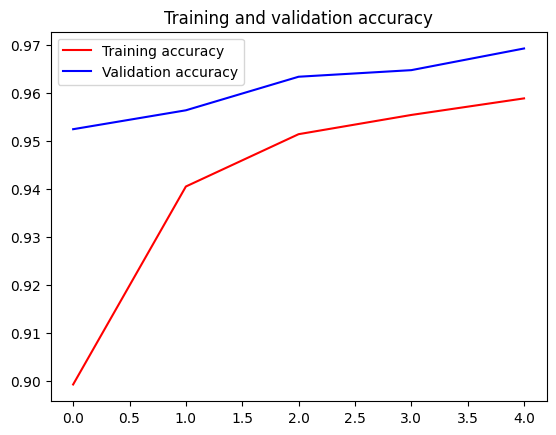

<Figure size 640x480 with 0 Axes>

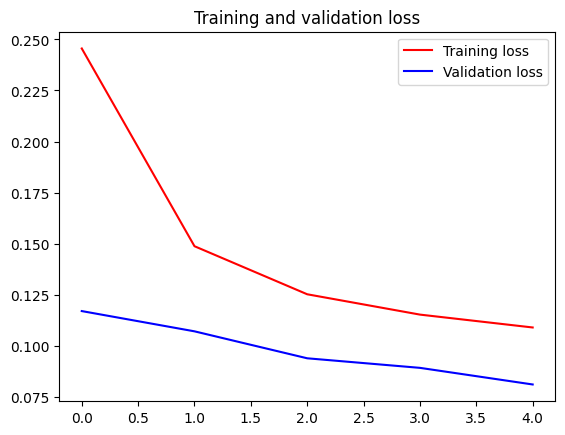

<Figure size 640x480 with 0 Axes>

In [41]:
plot_image(history)

# **Model Evaluation**

Confussion Matrix

313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 151ms/step
True classes length: 20001
Predicted classes length: 20001


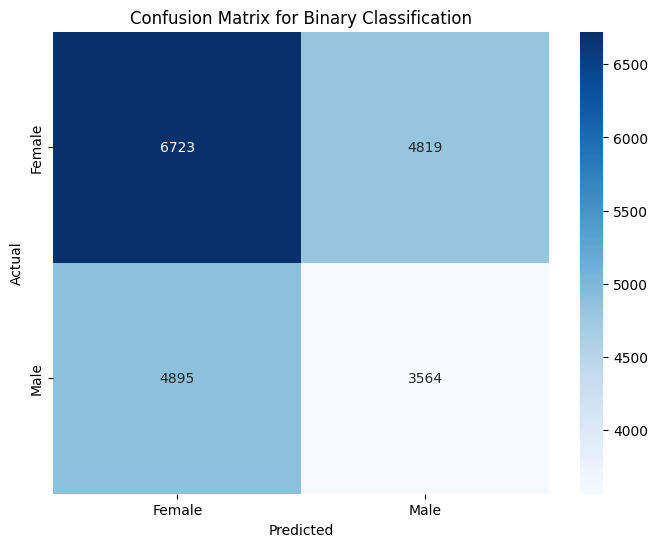

In [44]:
predicted_probabilities = model.predict(test_generator, verbose=1)

predicted_classes = (predicted_probabilities >= 0.5).astype(int)

true_classes = test_generator.classes 

print(f"True classes length: {len(true_classes)}")
print(f"Predicted classes length: {len(predicted_classes)}")

if len(true_classes) == len(predicted_classes):
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Gender Classification')
    plt.show()
else:
    print("Mismatch in the number of samples between true classes and predicted classes.")


Classification Report

In [46]:
print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.58      0.58      0.58     11542
           1       0.43      0.42      0.42      8459

    accuracy                           0.51     20001
   macro avg       0.50      0.50      0.50     20001
weighted avg       0.51      0.51      0.51     20001



Save history data to csv

In [47]:
history_data = {
    'epoch': range(1, len(history.history['loss']) + 1),
    'train_loss': history.history['loss'],
    'train_accuracy': history.history['accuracy'],
    'val_loss': history.history['val_loss'],
    'val_accuracy': history.history['val_accuracy']
}

history_df = pd.DataFrame(history_data)

print(history_df)

   epoch  train_loss  train_accuracy  val_loss  val_accuracy
0      1    0.245541        0.899300  0.117012      0.952474
1      2    0.148755        0.940538  0.107096      0.956412
2      3    0.125233        0.951437  0.093900      0.963404
3      4    0.115282        0.955444  0.089218      0.964776
4      5    0.108982        0.958894  0.081082      0.969289


In [48]:
model.save('gender.h5')